In [174]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.svm import SVC, NuSVC
from sklearn.mixture import GaussianMixture
from sklearn import linear_model, ensemble
from sklearn.model_selection import train_test_split
from scipy.signal import find_peaks_cwt
from FeatureAnalysis import RescalePCA, HistFeature, FFTFeature
from DataProcessing import ToPandasData, DataCombiner, DataAugmentor
from DataVisulization import VisCompareTwoPCA, VisMeasurements, VisFFTResult, VisTrainVsTest, VisPredResult
import random
import time
# keras
from keras.layers import Dense, Dropout, LSTM
from keras.models import Sequential
from keras.utils import np_utils

In [175]:
DATA_COMBINER = DataCombiner()
# convert all trial data and to be ready to pass in to the PCA 
# structure: {gait_type:{trial_name: total_trial_num}}
All_gait_trials = {'normal': ('Normal', 5), 'normal_2': ('Normal',5), 'normal_3':('Normal', 6),'ran':('Normal', 3), 'normal_04':('Normal', 6),'normal_05':('Normal', 5),
                   'side':('Outward', 5), 'side_2':('Outward', 5),'ran_side':('Outward', 5),
                   'inward_01': ('Inward', 5),
                   'line_01':('Tandem', 5)}

In [176]:
DATA_COMBINER.loadTrialData(All_gait_trials, '../Data_Collection/','.txt')
All_combined_data = DATA_COMBINER.combineAllData()
gait_types = DATA_COMBINER.label_order

Start Loading: From txt files into Pandas
Finish Loading: Time taken 2.067 sec

Start Combining: Combine specific type trials under each general type
Finish Combining: Time taken 0.046 sec



In [177]:
DATA_AUG = DataAugmentor(All_combined_data)
aug_all_types = DATA_AUG.all_types
All_aug_data = DATA_AUG.subSampleAll(out_length=400, num_draw=2500, std_percentile= 10)

Start Data Augmentation: subsample data from combined data and add noise
Finish Augmenting Data: Normal, Time Taken 11.911 sec
Finish Augmenting Data: Side Walk, Time Taken 11.807 sec
Finish Augmenting Data: Inward, Time Taken 12.355 sec
Finish Augmenting Data: Line, Time Taken 11.989 sec
Finish All Data Augmentation, Time Taken: 48.063 sec



In [178]:
# put all raw trials into a single df to apply PCA
list_all_raw_data = []
for each_gen in All_combined_data:
    for each_spec in All_combined_data[each_gen]:
        list_all_raw_data.append(All_combined_data[each_gen][each_spec])
all_trial_df = pd.concat(list_all_raw_data)

PCA_all = RescalePCA()
reduced_dim = 3
PCA_all.processRescalePCA(all_trial_df, reduced_dim)
print(PCA_all)

PCA Info: 
[0.37819745 0.33595456 0.13056948]
Rescale Info:
Voltage_01: (1.0, 0.0)
Voltage_02: (1.0, 0.0)
Acc_x: (48.0, -78.47)
Acc_y: (38.43, -77.24)
Acc_z: (78.47, -38.96)
Gyro_x: (4.28, -4.28)
Gyro_y: (4.28, -4.28)
Gyro_z: (4.28, -4.28)
Component Range: 
[-0.61 -0.56 -0.49]
[0.7  0.81 0.61]
Feature Order: {'Voltage_01': 0, 'Voltage_02': 1, 'Acc_x': 2, 'Acc_y': 3, 'Acc_z': 4, 'Gyro_x': 5, 'Gyro_y': 6, 'Gyro_z': 7}


In [179]:
num_hist_bins = 20
num_fft_features = 10
cut_off = 100
def GetAllFeatures(pca_data, component_range, num_hist_bins,
                   time_data, cut_off, num_fft_bins):
    return np.hstack((HistFeature(pca_data, component_range, num_hist_bins), 
                                         FFTFeature(pca_data,sample['Time'], cut_off, num_fft_bins)))

In [180]:
# combine all the trials data into HistFeatures and combined into a matrix for modeling training 
# buffer the feature matrix and label array
num_train_samples = sum([len(All_aug_data[each_type]) for each_type in All_aug_data])
train_matrix = np.zeros((num_train_samples, reduced_dim * num_hist_bins + reduced_dim * num_fft_features))
train_labels = np.zeros(num_train_samples)
# process each sample for the hist features
idx = 0
raw_mea_matrix = []
print('Strat Feature Extraction: ')
for each_type in All_aug_data:
    cur_ini_time = time.time()
    cur_samples = All_aug_data[each_type]
    cur_type_idx = gait_types.index(each_type)
    for sample in cur_samples:
        raw_mea_matrix.append(sample[list(sample)[:-1]])
        cur_pca = PCA_all.applyRescalePCA(sample)
        train_matrix[idx,:] = GetAllFeatures(cur_pca, PCA_all.component_range, num_hist_bins,
                                            sample['Time'], cut_off, num_fft_features)
        train_labels[idx] = cur_type_idx
        idx += 1
    print(each_type + " Completed: Time Taken: " + str(round(time.time() - cur_ini_time, 3)) + ' sec ...')
print('All Feature Extractions Completed, Ready to Train Model')

Strat Feature Extraction: 
Normal Completed: Time Taken: 14.84 sec ...
Side Walk Completed: Time Taken: 16.237 sec ...
Inward Completed: Time Taken: 16.869 sec ...
Line Completed: Time Taken: 15.174 sec ...
All Feature Extractions Completed, Ready to Train Model


In [181]:
log_ini_time = time.time()
# Test if logistc regrisson works 
test_log = linear_model.LogisticRegression()
test_log.fit(train_matrix, train_labels)
print('Logistic Regression Model Trained, Time Taken: ' + str(round(time.time() - log_ini_time, 3)) + ' sec')

svm_ini_time = time.time()
# Support vector machine  
test_svc = NuSVC(probability=True, gamma=1/1000, kernel='linear')
test_svc.fit(train_matrix, train_labels)
print('SVM Model Trained, Time Taken: ' + str(round(time.time() - svm_ini_time, 3)) + ' sec')

gbt_ini_time = time.time()
# Gradient Boosting Ensemble
test_gbt = ensemble.GradientBoostingClassifier()
test_gbt.fit(train_matrix, train_labels)
print('GBT Model Trained, Time Taken: ' + str(round(time.time() - gbt_ini_time, 3)) + ' sec')

Logistic Regression Model Trained, Time Taken: 0.508 sec
SVM Model Trained, Time Taken: 61.892 sec
GBT Model Trained, Time Taken: 18.361 sec


In [182]:
def ReadDataForTest(trial_name, PCA_process_obj, num_hist_bins, cut_off, num_fft_features):
    test_case = ToPandasData('../Data_Collection/' + trial_name + '.txt')
    # split the test_case into many subsamples for classification 
    # the result will be the average of all proab
    
    test_in = PCA_all.applyRescalePCA(test_case)
    test_fea = GetAllFeatures(test_in, PCA_process_obj.component_range, num_hist_bins, 
                             test_case['Time'], cut_off, num_fft_features)
    return {'Trial_Name': trial_name,
            'Raw Data': test_case, 
            'PCA Data': test_in, 
            'Features': test_fea}

In [208]:
all_test_data = []
test_trials_type = 'test_side_01'
for idx in range(1,5):
    cur_case_name = test_trials_type + '_0' + str(idx)
    cur_test_case = ReadDataForTest(cur_case_name, PCA_all, num_hist_bins, cut_off, num_fft_features)
    all_test_data.append(cur_test_case)

Log


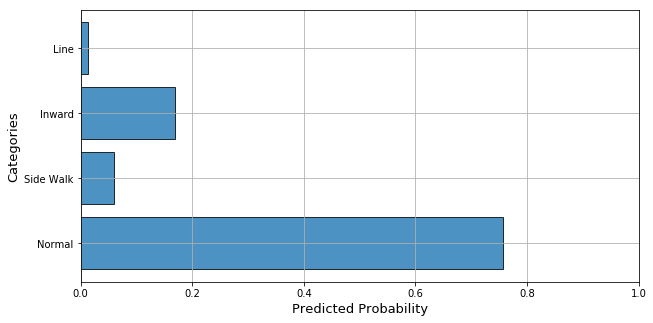

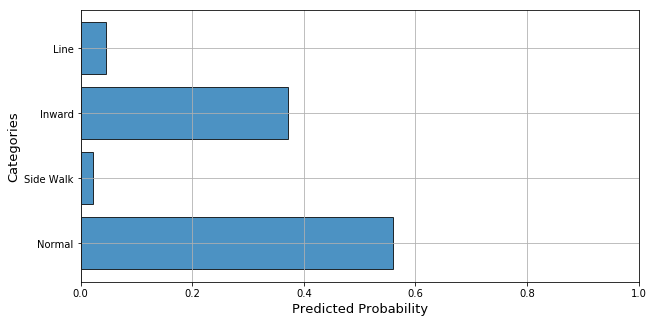

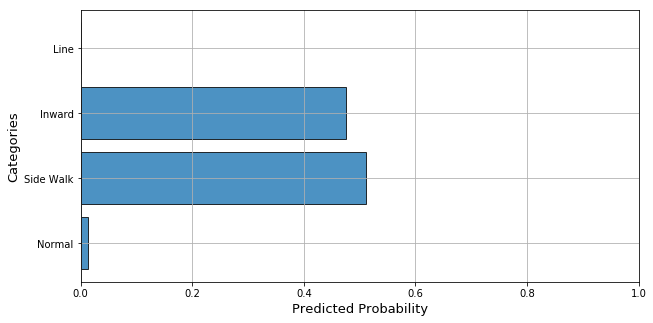

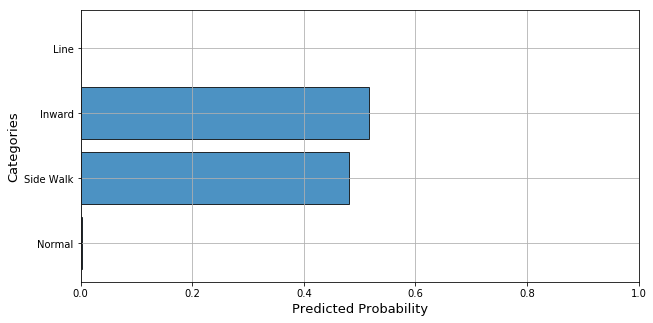

In [209]:
print('Log')
for idx in range(len(all_test_data)):
    cur_test_fea = all_test_data[idx]['Features']
    VisPredResult(test_log.predict_proba([cur_test_fea])[0], gait_types, str(idx) + ' ' + "Log")

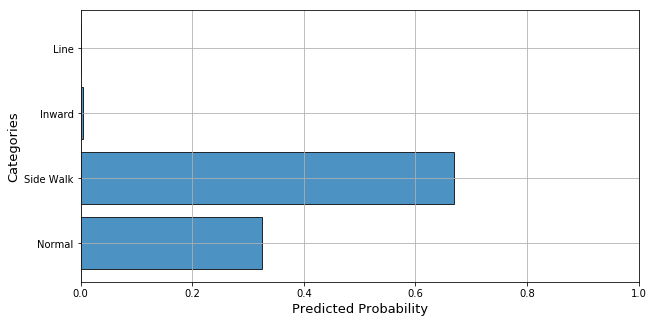

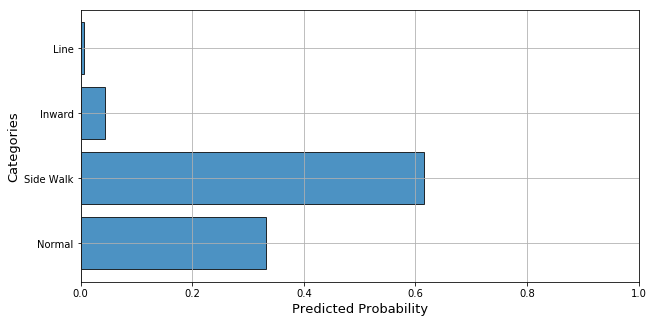

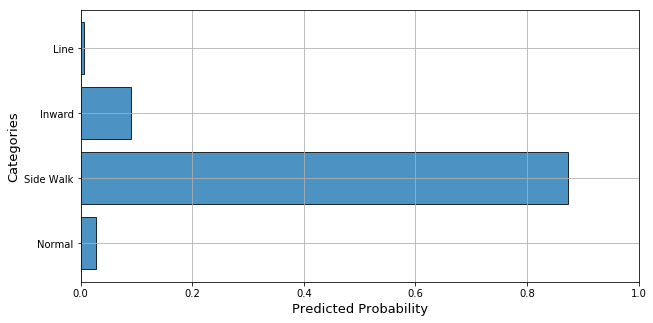

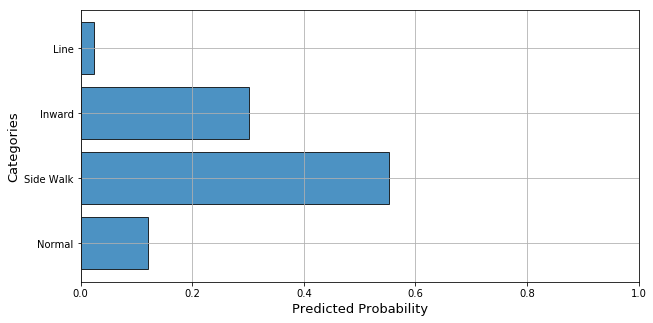

In [210]:
for idx in range(len(all_test_data)):
    cur_test_fea = all_test_data[idx]['Features']
    VisPredResult(test_svc.predict_proba([cur_test_fea])[0], gait_types, str(idx) + ' ' + "SVM")

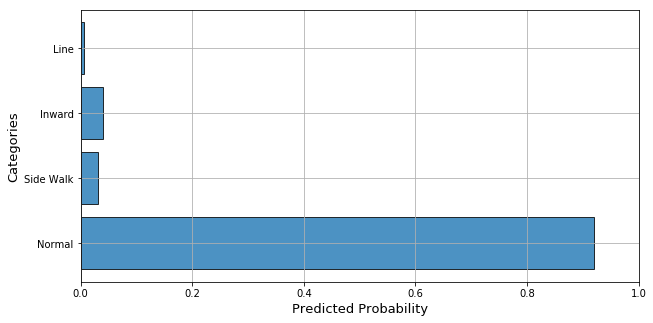

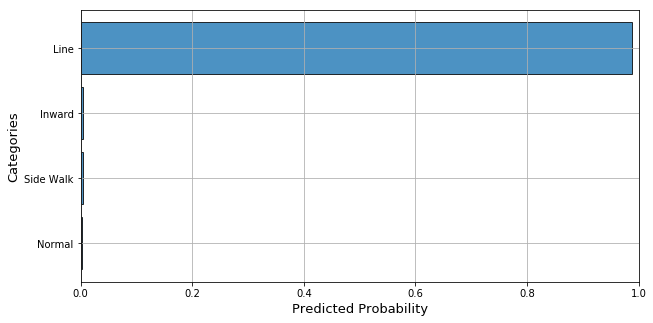

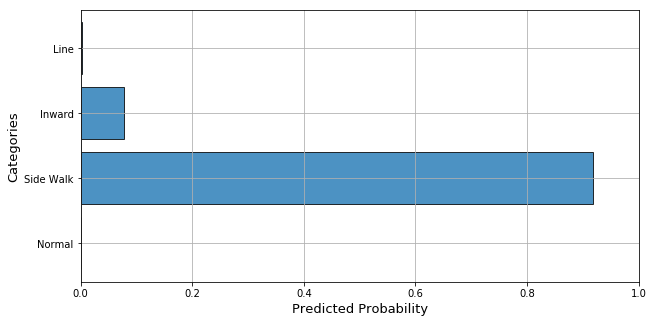

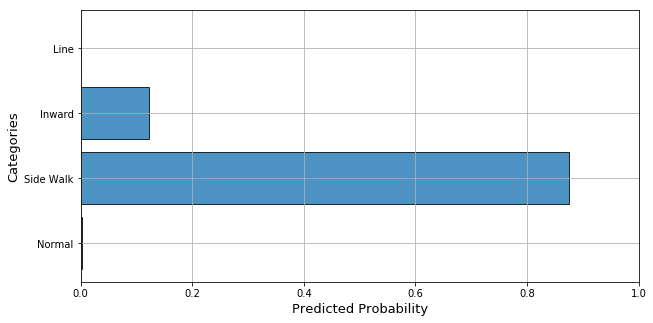

In [211]:
for idx in range(len(all_test_data)):
    cur_test_fea = all_test_data[idx]['Features']
    VisPredResult(test_gbt.predict_proba([cur_test_fea])[0], gait_types, str(idx+1) + ' ' + "GBT")

In [199]:
def KerasFormat(old_x, old_y):
    '''k for keras'''
    k_y = np_utils.to_categorical(old_y)
    k_x = np.array([np.array(each) for each in old_x])
    return k_x, k_y

k_x, k_y = KerasFormat(raw_mea_matrix, train_labels)
X_train, X_test, y_train, y_test = train_test_split(k_x, k_y, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(15, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(len(gait_types), activation = 'softmax'))
model.compile(loss='categorical_crossentropy',
                  optimizer='rmsprop',
                  metrics=['accuracy'])
lstm_ini_time = time.time()
hist = model.fit(X_train, y_train, batch_size= min(15000,X_train.shape[0]), shuffle = True,
                 epochs= 250, validation_split = 0.1, verbose = 1)
print('LSTM Model Trained, Time Taken: ' + str(round(time.time() - lstm_ini_time, 3)) + ' sec')

Train on 7202 samples, validate on 801 samples
Epoch 1/250
7202/7202 [==============================] - 2s 322us/step - loss: 1.4920 - acc: 0.2131 - val_loss: 1.4531 - val_acc: 0.2235
Epoch 2/250
7202/7202 [==============================] - 1s 143us/step - loss: 1.4676 - acc: 0.2216 - val_loss: 1.4346 - val_acc: 0.2235
Epoch 3/250
7202/7202 [==============================] - 1s 144us/step - loss: 1.4476 - acc: 0.2320 - val_loss: 1.4244 - val_acc: 0.2222
Epoch 4/250
7202/7202 [==============================] - 1s 150us/step - loss: 1.4396 - acc: 0.2349 - val_loss: 1.4174 - val_acc: 0.2197
Epoch 5/250
7202/7202 [==============================] - 1s 140us/step - loss: 1.4290 - acc: 0.2391 - val_loss: 1.4111 - val_acc: 0.2272
Epoch 6/250
7202/7202 [==============================] - 1s 141us/step - loss: 1.4189 - acc: 0.2478 - val_loss: 1.4060 - val_acc: 0.2285
Epoch 7/250
7202/7202 [==============================] - 1s 149us/step - loss: 1.4147 - acc: 0.2530 - val_loss: 1.4007 - val_acc: 0

7202/7202 [==============================] - 1s 145us/step - loss: 1.1929 - acc: 0.4919 - val_loss: 1.1671 - val_acc: 0.5181
Epoch 61/250
7202/7202 [==============================] - 1s 136us/step - loss: 1.1857 - acc: 0.4993 - val_loss: 1.1619 - val_acc: 0.5181
Epoch 62/250
7202/7202 [==============================] - 1s 135us/step - loss: 1.1778 - acc: 0.5031 - val_loss: 1.1573 - val_acc: 0.5156
Epoch 63/250
7202/7202 [==============================] - 1s 141us/step - loss: 1.1731 - acc: 0.5082 - val_loss: 1.1505 - val_acc: 0.5206
Epoch 64/250
7202/7202 [==============================] - 1s 155us/step - loss: 1.1630 - acc: 0.5176 - val_loss: 1.1450 - val_acc: 0.5243
Epoch 65/250
7202/7202 [==============================] - 1s 143us/step - loss: 1.1601 - acc: 0.5140 - val_loss: 1.1396 - val_acc: 0.5306
Epoch 66/250
7202/7202 [==============================] - 1s 147us/step - loss: 1.1553 - acc: 0.5190 - val_loss: 1.1334 - val_acc: 0.5356
Epoch 67/250
7202/7202 [=======================

Epoch 120/250
7202/7202 [==============================] - 1s 150us/step - loss: 0.7445 - acc: 0.7644 - val_loss: 0.7165 - val_acc: 0.7753
Epoch 121/250
7202/7202 [==============================] - 1s 152us/step - loss: 0.7352 - acc: 0.7671 - val_loss: 0.7086 - val_acc: 0.7815
Epoch 122/250
7202/7202 [==============================] - 1s 131us/step - loss: 0.7291 - acc: 0.7706 - val_loss: 0.6998 - val_acc: 0.7828
Epoch 123/250
7202/7202 [==============================] - 1s 147us/step - loss: 0.7200 - acc: 0.7670 - val_loss: 0.6900 - val_acc: 0.7878
Epoch 124/250
7202/7202 [==============================] - 1s 130us/step - loss: 0.7111 - acc: 0.7731 - val_loss: 0.6803 - val_acc: 0.7953
Epoch 125/250
7202/7202 [==============================] - 1s 131us/step - loss: 0.7056 - acc: 0.7792 - val_loss: 0.6726 - val_acc: 0.7903
Epoch 126/250
7202/7202 [==============================] - 1s 135us/step - loss: 0.6926 - acc: 0.7794 - val_loss: 0.6634 - val_acc: 0.7990
Epoch 127/250
7202/7202 [==

Epoch 179/250
7202/7202 [==============================] - 1s 140us/step - loss: 0.2762 - acc: 0.9611 - val_loss: 0.2475 - val_acc: 0.9700
Epoch 180/250
7202/7202 [==============================] - 1s 170us/step - loss: 0.2667 - acc: 0.9642 - val_loss: 0.2515 - val_acc: 0.9700
Epoch 181/250
7202/7202 [==============================] - 1s 168us/step - loss: 0.2594 - acc: 0.9690 - val_loss: 0.2474 - val_acc: 0.9700
Epoch 182/250
7202/7202 [==============================] - 1s 156us/step - loss: 0.2603 - acc: 0.9661 - val_loss: 0.2393 - val_acc: 0.9725
Epoch 183/250
7202/7202 [==============================] - 1s 142us/step - loss: 0.2539 - acc: 0.9681 - val_loss: 0.2356 - val_acc: 0.9738
Epoch 184/250
7202/7202 [==============================] - 1s 137us/step - loss: 0.2511 - acc: 0.9681 - val_loss: 0.2320 - val_acc: 0.9738
Epoch 185/250
7202/7202 [==============================] - 1s 132us/step - loss: 0.2479 - acc: 0.9683 - val_loss: 0.2287 - val_acc: 0.9738
Epoch 186/250
7202/7202 [==

Epoch 238/250
7202/7202 [==============================] - 1s 165us/step - loss: 0.1277 - acc: 0.9874 - val_loss: 0.1167 - val_acc: 0.9850
Epoch 239/250
7202/7202 [==============================] - 1s 154us/step - loss: 0.1250 - acc: 0.9871 - val_loss: 0.1198 - val_acc: 0.9825
Epoch 240/250
7202/7202 [==============================] - 1s 138us/step - loss: 0.1289 - acc: 0.9865 - val_loss: 0.1152 - val_acc: 0.9838
Epoch 241/250
7202/7202 [==============================] - 1s 139us/step - loss: 0.1240 - acc: 0.9865 - val_loss: 0.1136 - val_acc: 0.9850
Epoch 242/250
7202/7202 [==============================] - 1s 133us/step - loss: 0.1224 - acc: 0.9872 - val_loss: 0.1146 - val_acc: 0.9850
Epoch 243/250
7202/7202 [==============================] - 1s 159us/step - loss: 0.1263 - acc: 0.9856 - val_loss: 0.1079 - val_acc: 0.9875
Epoch 244/250
7202/7202 [==============================] - 1s 153us/step - loss: 0.1176 - acc: 0.9875 - val_loss: 0.1064 - val_acc: 0.9850
Epoch 245/250
7202/7202 [==

[0.22874704 0.7218639  0.02893016 0.02045888]
[0.09330393 0.858377   0.03480592 0.01351328]
[0.0119777  0.95781136 0.02780826 0.00240266]
[0.0167337  0.9518475  0.02727833 0.0041404 ]


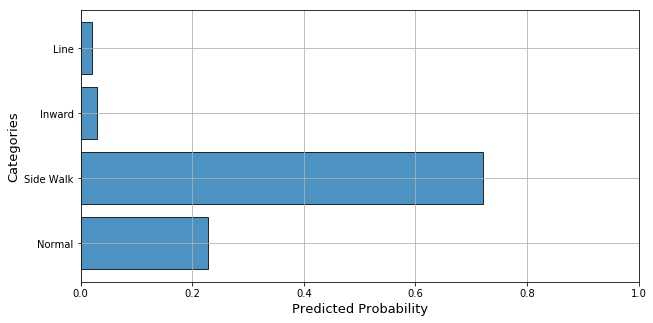

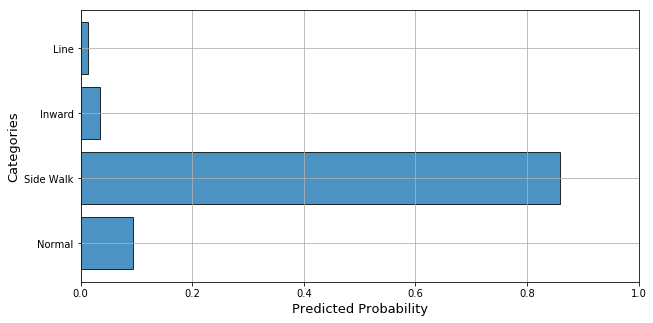

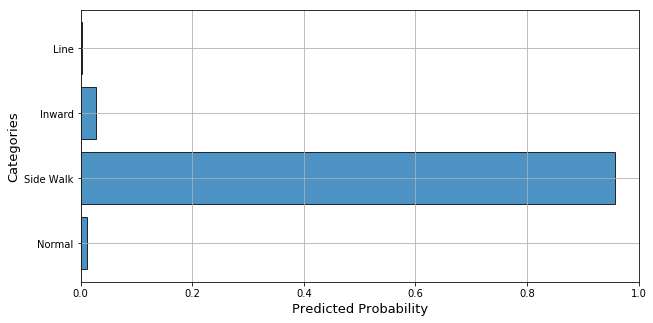

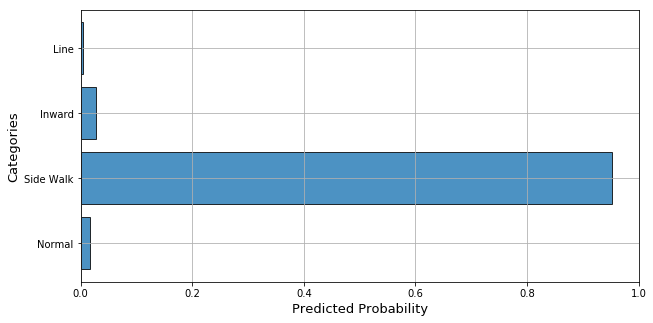

In [200]:
for idx in range(len(all_test_data)):
    test_case = all_test_data[idx]['Raw Data']
    sum_prob = np.zeros((1,4))
    test_case_len, stride = test_case.shape[0], 50
    test_x = []
    input_len = 400
    for idx in range(0, test_case_len - input_len, stride):
        cur_sub = np.array(test_case[list(test_case)[:-1]][idx: input_len + idx])[np.newaxis::]
        test_x.append(cur_sub)
    test_x = np.stack(test_x)
    test_y = np.mean(model.predict_proba(test_x),axis=0)
    print(test_y)
    VisPredResult(test_y, gait_types,"LSTM")


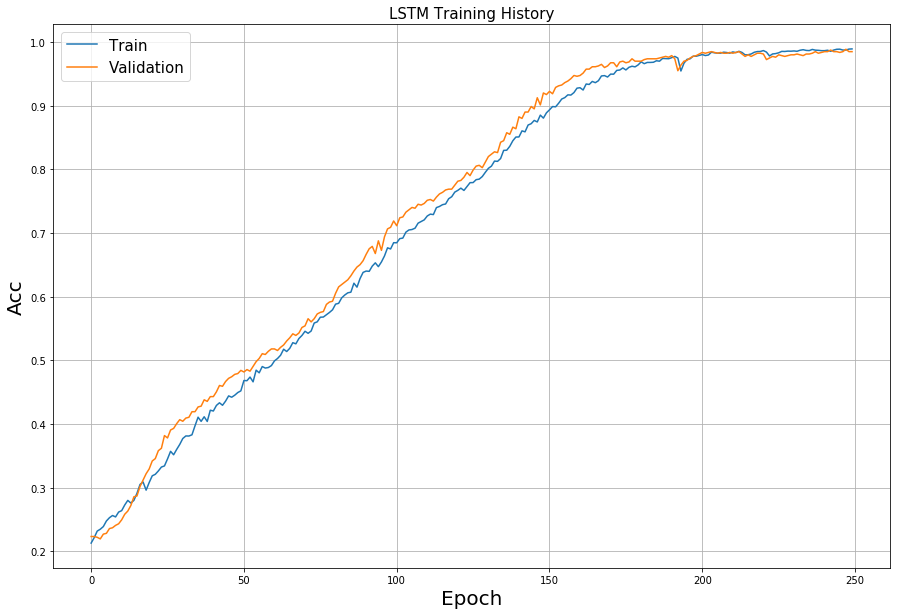

In [201]:
plt.figure(figsize=(15,10))
plt.plot(hist.history['acc'], label = 'Train')
plt.plot(hist.history['val_acc'], label = 'Validation')
plt.xlabel('Epoch', fontsize = 20)
plt.ylabel('Acc', fontsize = 20)
plt.legend(fontsize = 15)
plt.title('LSTM Training History', fontsize = 15)
plt.grid()

In [191]:
valid_x = hist.validation_data[0]
valid_y = hist.validation_data[1]
valid_pred = model.predict(valid_x, batch_size=32)

In [192]:
from sklearn.metrics import roc_auc_score
for idx in range(4):
    print(roc_auc_score(valid_y[:,idx], valid_pred[:,idx]))

0.9961610893814283
0.9925370667283757
0.9825928457507405
0.9810745858724572


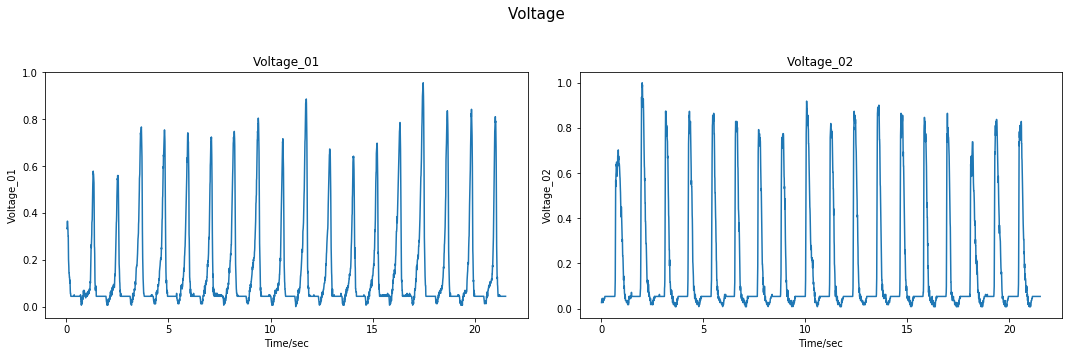

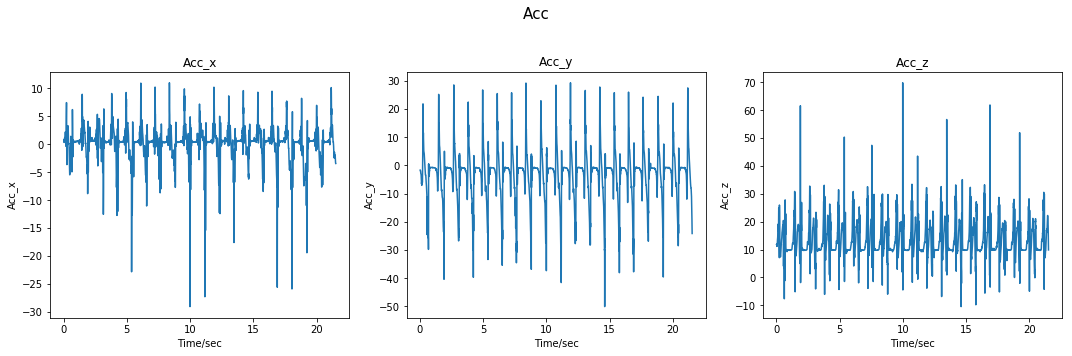

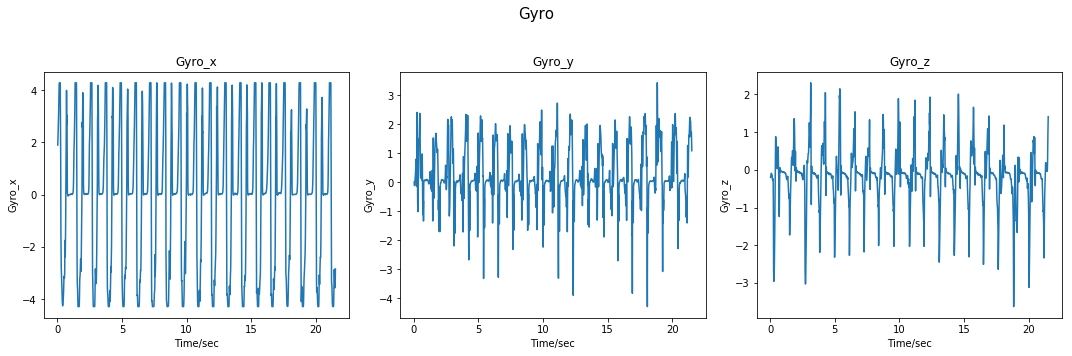

In [202]:
VisMeasurements(ToPandasData('../Data_Collection/normal_01.txt'))

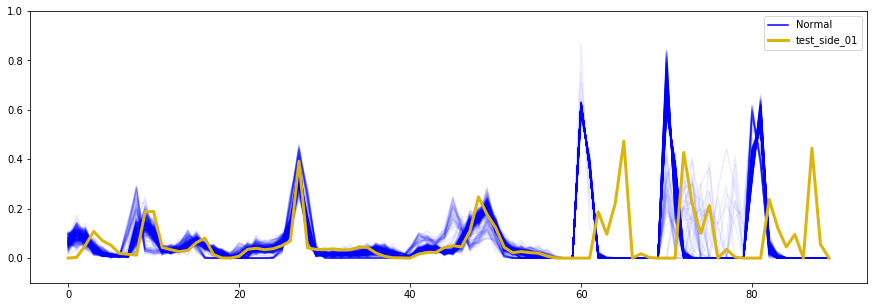

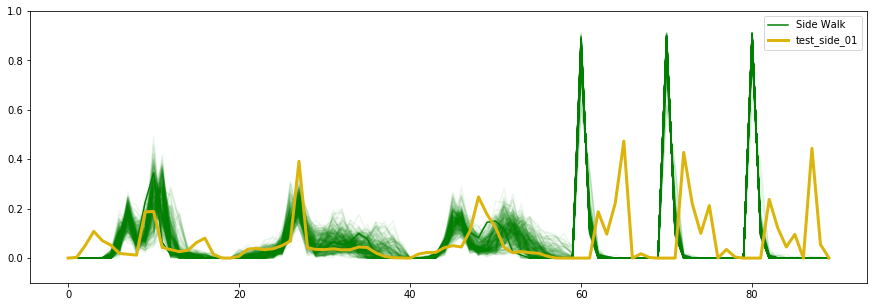

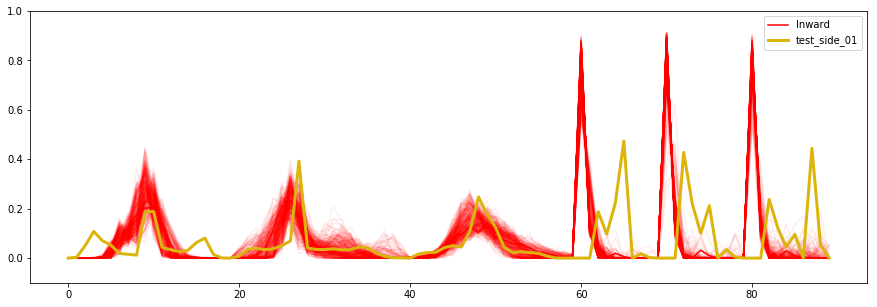

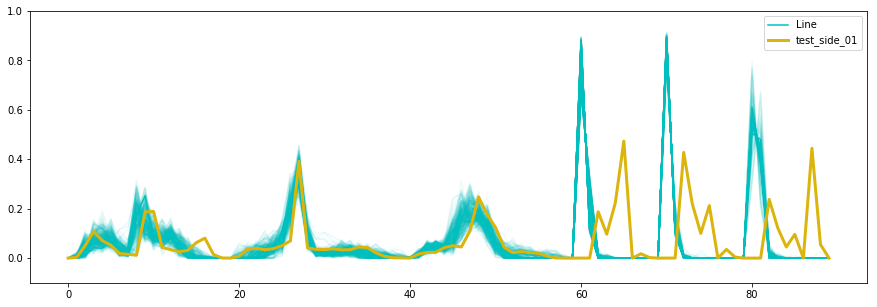

In [194]:
VisTrainVsTest(train_matrix, train_labels, gait_types, all_test_data[1]['Features'], test_trials_type)

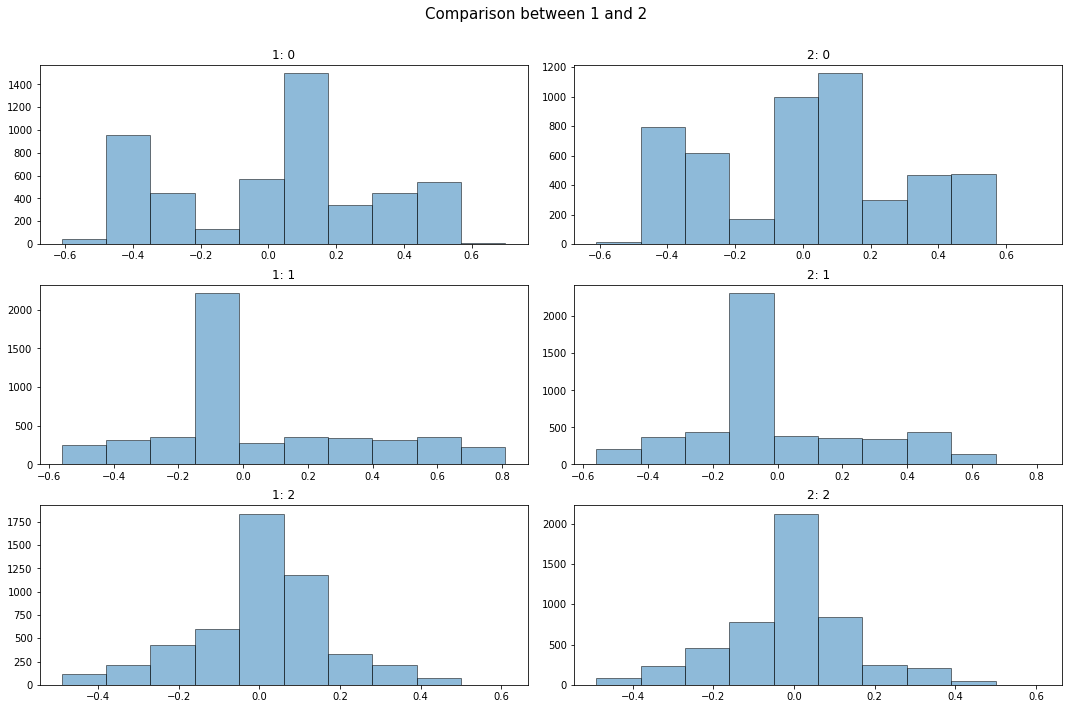

In [195]:
VisCompareTwoPCA(all_test_data[0]['PCA Data'], all_test_data[1]['PCA Data'], PCA_all, '1','2')

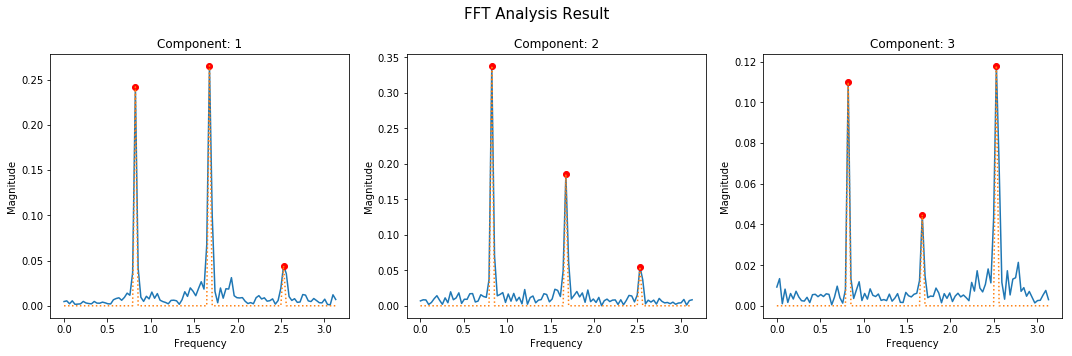

In [207]:
VisFFTResult(all_test_data[0]['PCA Data'], all_test_data[0]['Raw Data']['Time'], 100)